In [79]:
import json
import time
import numpy
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alena.ogloblina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [113]:
from rutermextract import TermExtractor
from flashtext.keyword import KeywordProcessor

In [50]:
def getData():
    data = []
    with open('data.txt', 'r') as f:
        for line in f:
            data.append(json.loads(str(line)))
    return data

In [60]:
def getAspects():
  f = open('aspects.txt', 'r')
  content = f.read()
  f.close()
  return content.split(";")

In [64]:
def getLemmAspects():
    lem_aspect = []
    for aspect in aspects:
        res = prepare_text(aspect)
        lem_aspect.append(res) 
    return lem_aspect

In [65]:
def prepare_text(text):
  tokens = mystem.lemmatize(text.lower())
  tokens = [token for token in tokens if token not in russian_stopwords\
            and token != " " \
            and token.strip() not in punctuation]
  
  text = " ".join(tokens)
  return text

In [66]:
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

In [67]:
data = getData()
aspects = getAspects()
aspects_lemm = getLemmAspects()

<h2> 1. Примитивный поиск подстроки в строке </h2>

In [54]:
data_lemm = [prepare_text(data_item['dec']) for data_item in data]

In [69]:
def search_simple(haystack, needle):
    index = -1
    for i in range(len(haystack)-len(needle)+1):
        success = True
        for j in range(len(needle)):
            if needle[j]!=haystack[i+j]:
                success = False
                break
        if success:
            index = i
            break
    return index != -1

In [224]:
def CalculateStatsForSimpleSarch():
    res_task = []
    rub_task = []
    time_task = []

    for task_index in range(0, len(data_lemm)):
        start_time = time.time()
        res_aspect = []
        for aspect_index in range(0, len(aspects_lemm)):
            if search_simple(data_lemm[task_index], aspects_lemm[aspect_index]):
                res_aspect.append(aspects[aspect_index])

        time_task.append(time.time() - start_time)
        sum = 0
        rub = 0

        real_aspects = data[task_index]['asp'].split(", ")
        for res_asp in res_aspect:
            if (res_asp in real_aspects):
                sum += 1
            else:
                rub += 1
        if (len(res_aspect)!=0):
            res_task.append(sum/len(real_aspects))
            rub_task.append(rub/len(res_aspect))
        else:
            res_task.append(0)
            rub_task.append(0)
    return numpy.mean(res_task), numpy.mean(rub_task), numpy.mean(time_task)

In [225]:
print(CalculateStatsForSimpleSarch())

(0.19097744360902255, 0.11278195488721804, 0.02898113351119192)


<h2> 2. Поиск подстроки в строке алгоритмом Кунна-Морриса-Прата</h2>

In [226]:
def search_kmp(text, pattern):
    pattern = list(pattern)

    shifts = [1] * (len(pattern) + 1)
    shift = 1
    for pos in range(len(pattern)):
        while shift <= pos and pattern[pos] != pattern[pos-shift]:
            shift += shifts[pos-shift]
        shifts[pos+1] = shift

    # do the actual search
    startPos = 0
    matchLen = 0
    for c in text:
        while matchLen == len(pattern) or \
              matchLen >= 0 and pattern[matchLen] != c:
            startPos += shifts[matchLen]
            matchLen -= shifts[matchLen]
        matchLen += 1
        if matchLen == len(pattern):
            return startPos != 0

In [227]:
def CalculateStatsForKMP():
    res_task = []
    rub_task = []
    time_task = []

    for task_index in range(0, len(data_lemm)):
        start_time = time.time()
        res_aspect = []
        for aspect_index in range(0, len(aspects_lemm)):
            if search_kmp(data_lemm[task_index], aspects_lemm[aspect_index]):
                res_aspect.append(aspects[aspect_index])

        time_task.append(time.time() - start_time)
        sum = 0
        rub = 0

        real_aspects = data[task_index]['asp'].split(", ")
        for res_asp in res_aspect:
            if (res_asp in real_aspects):
                sum += 1
            else:
                rub += 1
        if (len(res_aspect)!=0):
            res_task.append(sum/len(real_aspects))
            rub_task.append(rub/len(res_aspect))
        else:
            res_task.append(0)
            rub_task.append(0)
    return numpy.mean(res_task), numpy.mean(rub_task), numpy.mean(time_task)

In [228]:
print(CalculateStatsForKMP())

(0.18721804511278195, 0.11403508771929827, 0.03290329481426038)


<h2> 3. Выделение ключевых слов с помощью библиотеки FlashText</h2>

In [121]:
keyword_processor = KeywordProcessor()
for aspect in aspects:
    keyword_processor.add_keyword(aspect)

def search_flashtext(haystack):
    keywords_found = keyword_processor.extract_keywords(haystack)
    return keywords_found

In [229]:
def CalculateStatsForFlashText():
    res_task = []
    rub_task = []
    time_task = []

    for task in data:
        start_time = time.time()
        res_aspect = []

        res = search_flashtext(task['dec'])
        if res != "":
            res_aspect = res
            
        time_task.append(time.time() - start_time)
        sum = 0
        rub = 0

        real_aspects = task['asp'].split(", ")
        for res_asp in res_aspect:
            if (res_asp in real_aspects):
                sum += 1
            else:
                rub += 1
        if (len(res_aspect)!=0):
            res_task.append(sum/len(real_aspects))
            rub_task.append(rub/len(res_aspect))
        else:
            res_task.append(0)
            rub_task.append(0)
    return numpy.mean(res_task), numpy.mean(rub_task), numpy.mean(time_task)

In [230]:
print(CalculateStatsForFlashText())

(0.2662907268170426, 0.03508771929824561, 0.0005381860231098376)


<h2> 4. Выделение ключевых слов с помощью библиотеки Rutermextract</h2>

In [136]:
def search_rutermextract(haystack):
    result = []
    term_extractor = TermExtractor()
    for term in term_extractor(haystack):
        result.append(term.normalized)
    return result

In [141]:
import difflib

In [167]:
def CalculateStatsForRutermextract():
    res_task = []
    rub_task = []
    time_task = []

    for task in data:
        start_time = time.time()
        res_aspect = []

        res = search_rutermextract(task['dec'])
        if res != "":
            for res_item in res:
                neibor = difflib.get_close_matches(res_item, aspects, n=1)
                if len(neibor)!= 0:
                    res_aspect.append(neibor[0])
            
        time_task.append(time.time() - start_time)
        sum = 0
        rub = 0

        real_aspects = task['asp'].split(", ")
        for res_asp in res_aspect:
            if (res_asp in real_aspects):
                sum += 1
            else:
                rub += 1
        if (len(res_aspect)!=0):
            res_task.append(sum/len(real_aspects))
            rub_task.append(rub/len(res_aspect))
        else:
            res_task.append(0)
            rub_task.append(0)
    return numpy.mean(res_task), numpy.mean(rub_task), numpy.mean(time_task)

In [168]:
print(CalculateStatsForRutermextract())

(0.4197994987468672, 0.6011085405822248, 0.13258710660432516)


<h2>Модифицированная версия подстроки в строке.</h2>

In [232]:
def CalculateStatsForSimpleSarchModify(k):
    res_task = []
    rub_task = []
    time_task = []

    for task_index in range(0, len(data_lemm)):
        start_time = time.time()
        res_aspect = []
        for aspect_index in range(0, len(aspects_lemm)):
            aspect_list = aspects_lemm[aspect_index].split(" ")
            i = 0
            for aspect_item in aspect_list:
                if search_simple(data_lemm[task_index], aspect_item):
                    i += 1
            if i/len(aspect_list) > k:
                res_aspect.append(aspects[aspect_index])

        time_task.append(time.time() - start_time)
        sum = 0
        rub = 0

        real_aspects = data[task_index]['asp'].split(", ")
        for res_asp in res_aspect:
            if (res_asp in real_aspects):
                sum += 1
            else:
                rub += 1
        if (len(res_aspect)!=0):
            res_task.append(sum/len(real_aspects))
            rub_task.append(rub/len(res_aspect))
        else:
            res_task.append(0)
            rub_task.append(0)
    return numpy.mean(res_task), numpy.mean(rub_task), numpy.mean(time_task)

In [233]:
print(CalculateStatsForSimpleSarchModify(0.5))

(0.34636591478696743, 0.4095864661654135, 0.0889842384739926)


In [235]:
def CalculateStatsForKMPSarchModify(k):
    res_task = []
    rub_task = []
    time_task = []

    for task_index in range(0, len(data_lemm)):
        start_time = time.time()
        res_aspect = []
        for aspect_index in range(0, len(aspects_lemm)):
            aspect_list = aspects_lemm[aspect_index].split(" ")
            i = 0
            for aspect_item in aspect_list:
                if search_kmp(data_lemm[task_index], aspect_item):
                    i += 1
            if i/len(aspect_list) > k:
                res_aspect.append(aspects[aspect_index])

        time_task.append(time.time() - start_time)
        sum = 0
        rub = 0

        real_aspects = data[task_index]['asp'].split(", ")
        for res_asp in res_aspect:
            if (res_asp in real_aspects):
                sum += 1
            else:
                rub += 1
        if (len(res_aspect)!=0):
            res_task.append(sum/len(real_aspects))
            rub_task.append(rub/len(res_aspect))
        else:
            res_task.append(0)
            rub_task.append(0)
    return [numpy.mean(res_task), numpy.mean(rub_task), numpy.mean(time_task)]

In [236]:
print(CalculateStatsForKMPSarchModify(0.4))

[0.5482456140350878, 0.7824898699511703, 0.08070642069766396]


In [194]:
import matplotlib.pyplot as plt

In [214]:
x = []
y1 = []
y2 = []
y3 = []

def plotForKMPStats():
    for k in numpy.arange(0,1,0.1):
        res = CalculateStatsForKMPSarchModify(k)
        x.append(k)
        y1.append(res[0])
        y2.append(res[1])
        y3.append(res[2])

plotForKMPStats()

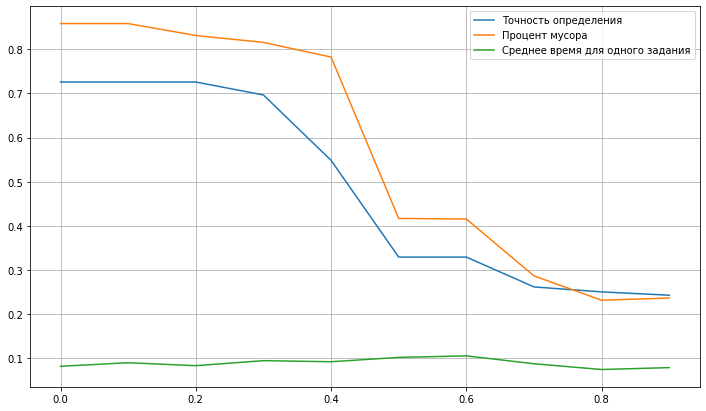

In [216]:
plt.figure(figsize=(12, 7))
plt.plot(x, y1, label="Точность определения")
plt.plot(x, y2, label="Процент мусора")
plt.plot(x, y3, label="Среднее время для одного задания")
plt.legend()
plt.grid(True)  

In [220]:
x_1 = []
y_1 = []
y_2 = []
y_3 = []

def plotForSimpleStats():
    for k in numpy.arange(0,1,0.1):
        res = CalculateStatsForSimpleSarchModify(k)
        x_1.append(k)
        y_1.append(res[0])
        y_2.append(res[1])
        y_3.append(res[2])

plotForSimpleStats()

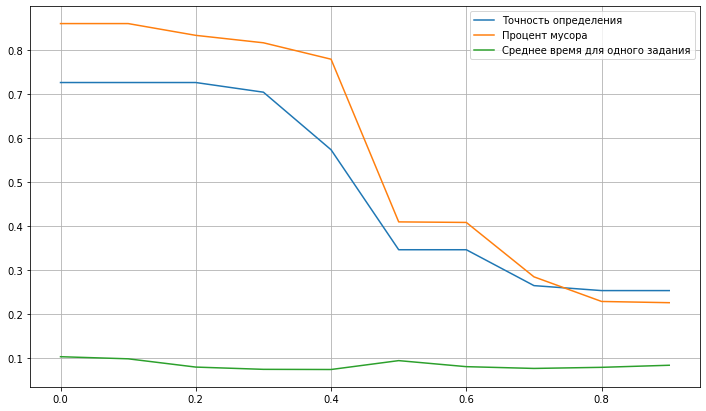

In [221]:
plt.figure(figsize=(12, 7))
plt.plot(x_1, y_1, label="Точность определения")
plt.plot(x_1, y_2, label="Процент мусора")
plt.plot(x_1, y_3, label="Среднее время для одного задания")
plt.legend()
plt.grid(True)